<a href="https://colab.research.google.com/github/Carlosrnes/group_work_ml/blob/main/Group_ML_Spot_Checking_for_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
# load libraries
import warnings
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Defined 35 models
>logistic: 0.662 (+/-0.035)
>ridge-0.1: 0.667 (+/-0.028)
>sgd: 0.601 (+/-0.142)
>pa: 0.420 (+/-0.255)
>knn-1: 0.556 (+/-0.042)
>knn-2: 0.504 (+/-0.038)
>knn-3: 0.598 (+/-0.032)
>knn-4: 0.570 (+/-0.039)
>knn-5: 0.612 (+/-0.039)
>knn-6: 0.582 (+/-0.041)
>knn-7: 0.610 (+/-0.047)
>knn-8: 0.593 (+/-0.038)
>knn-9: 0.614 (+/-0.048)
>knn-10: 0.603 (+/-0.045)
>knn-11: 0.626 (+/-0.038)
>knn-12: 0.613 (+/-0.041)
>knn-13: 0.630 (+/-0.034)
>knn-14: 0.609 (+/-0.034)
>knn-15: 0.627 (+/-0.038)
>knn-16: 0.617 (+/-0.039)
>knn-17: 0.628 (+/-0.044)
>knn-18: 0.612 (+/-0.044)
>knn-19: 0.631 (+/-0.037)
>knn-20: 0.621 (+/-0.039)
>cart: 0.580 (+/-0.031)
>extra: 0.558 (+/-0.030)
>svml: 0.662 (+/-0.025)
>svmp: 0.640 (+/-0.037)
>svmr0.6: 0.635 (+/-0.037)
>bayes: 0.298 (+/-0.003)
>ada: 0.614 (+/-0.031)
>bag: 0.599 (+/-0.034)
>rf: 0.583 (+/-0.047)
>et: 0.576 (+/-0.036)
>gbm: 0.637 (+/-0.040)

Rank=1, Name=ridge-0.1, Score=0.667 (+/- 0.028)
Rank=2, Name=svml, Score=0.662 (+/- 0.025)
Rank=3, Name=lo

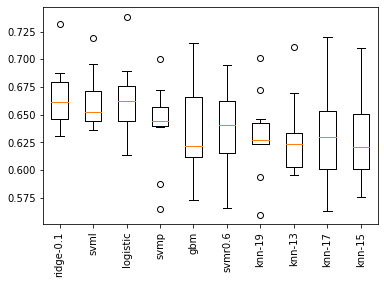

In [7]:
# binary classification spot check script

# load the dataset, returns X and y elements
def load_dataset():
	X = pd.read_csv('X_train.csv').drop(['Access_ID'], axis=1)
	y = pd.read_csv('y_train.csv')['Buy']
	return X, y

# create a dict of standard models to evaluate {name:object}
def define_models(models=dict()):
	# linear models
	models['logistic'] = LogisticRegression()
	alpha = [0.1] # excluded 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0
	for a in alpha:
		models['ridge-'+str(a)] = RidgeClassifier(alpha=a)
	models['sgd'] = SGDClassifier(max_iter=1000, tol=1e-3)
	models['pa'] = PassiveAggressiveClassifier(max_iter=1000, tol=1e-3)
	# non-linear models
	n_neighbors = range(1, 21)
	for k in n_neighbors:
		models['knn-'+str(k)] = KNeighborsClassifier(n_neighbors=k)
	models['cart'] = DecisionTreeClassifier()
	models['extra'] = ExtraTreeClassifier()
	models['svml'] = SVC(kernel='linear')
	models['svmp'] = SVC(kernel='poly')
	c_values = [0.6] # excluded 0.1, 0.2, 0.3, 0.4, 0.5, , 0.7, 0.8, 0.9, 1.0
	for c in c_values:
		models['svmr'+str(c)] = SVC(C=c)
	models['bayes'] = GaussianNB()
	# ensemble models
	n_trees = 100
	models['ada'] = AdaBoostClassifier(n_estimators=n_trees)
	models['bag'] = BaggingClassifier(n_estimators=n_trees)
	models['rf'] = RandomForestClassifier(n_estimators=n_trees)
	models['et'] = ExtraTreesClassifier(n_estimators=n_trees)
	models['gbm'] = GradientBoostingClassifier(n_estimators=n_trees)
	print('Defined %d models' % len(models))
	return models

# create a feature preparation pipeline for a model
def make_pipeline(model):
	steps = list()
	# standardization
	steps.append(('standardize', StandardScaler()))
	# normalization
	steps.append(('normalize', MinMaxScaler()))
	# the model
	steps.append(('model', model))
	# create pipeline
	pipeline = Pipeline(steps=steps)
	return pipeline

# evaluate a single model
def evaluate_model(X, y, model, folds, metric):
	# create the pipeline
	pipeline = make_pipeline(model)
	# evaluate model
	scores = cross_val_score(pipeline, X, y, scoring=metric, cv=folds, n_jobs=-1)
	return scores

# evaluate a model and try to trap errors and and hide warnings
def robust_evaluate_model(X, y, model, folds, metric):
	scores = None
	try:
		with warnings.catch_warnings():
			warnings.filterwarnings("ignore")
			scores = evaluate_model(X, y, model, folds, metric)
	except:
		scores = None
	return scores

# evaluate a dict of models {name:object}, returns {name:score}
def evaluate_models(X, y, models, folds=10, metric='f1'):
	results = dict()
	for name, model in models.items():
		# evaluate the model
		scores = robust_evaluate_model(X, y, model, folds, metric)
		# show process
		if scores is not None:
			# store a result
			results[name] = scores
			mean_score, std_score = mean(scores), std(scores)
			print('>%s: %.3f (+/-%.3f)' % (name, mean_score, std_score))
		else:
			print('>%s: error' % name)
	return results

# print and plot the top n results
def summarize_results(results, maximize=True, top_n=10):
	# check for no results
	if len(results) == 0:
		print('no results')
		return
	# determine how many results to summarize
	n = min(top_n, len(results))
	# create a list of (name, mean(scores)) tuples
	mean_scores = [(k,mean(v)) for k,v in results.items()]
	# sort tuples by mean score
	mean_scores = sorted(mean_scores, key=lambda x: x[1])
	# reverse for descending order (e.g. for accuracy)
	if maximize:
		mean_scores = list(reversed(mean_scores))
	# retrieve the top n for summarization
	names = [x[0] for x in mean_scores[:n]]
	scores = [results[x[0]] for x in mean_scores[:n]]
	# print the top n
	print()
	for i in range(n):
		name = names[i]
		mean_score, std_score = mean(results[name]), std(results[name])
		print('Rank=%d, Name=%s, Score=%.3f (+/- %.3f)' % (i+1, name, mean_score, std_score))
	# boxplot for the top n
	pyplot.boxplot(scores, labels=names)
	_, labels = pyplot.xticks()
	pyplot.setp(labels, rotation=90)
	pyplot.savefig('spotcheck.png')

# load dataset
X, y = load_dataset()
# get model list
models = define_models()
# evaluate models
results = evaluate_models(X, y, models)
# summarize results
summarize_results(results)

In [20]:
# Tune Ridge
alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
param_grid = dict(alpha=alphas)
model = RidgeClassifier()
kfold = KFold(n_splits=10, random_state=7, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1', cv=kfold)
grid_result = grid.fit(X, y)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.666796 using {'alpha': 1.0}
0.666796 (0.027615) with: {'alpha': 1.0}
0.666796 (0.027615) with: {'alpha': 0.1}
0.666796 (0.027615) with: {'alpha': 0.01}
0.666796 (0.027615) with: {'alpha': 0.001}
0.666796 (0.027615) with: {'alpha': 0.0001}
0.666796 (0.027615) with: {'alpha': 0.0}


In [26]:
# load validation
X_val = pd.read_csv('X_val.csv').drop(['Access_ID'], axis=1)
y_val = pd.read_csv('y_val.csv')['Buy']

# prepare the model
model = RidgeClassifier(alpha=1)
model.fit(X, y)
# estimate accuracy on validation dataset
predictions = model.predict(X_val)
print('f1_score:')
print(f1_score(y_val, predictions))
print('Confusion Matrix:')
print(confusion_matrix(y_val, predictions))
print('Classification Report:')
print(classification_report(y_val, predictions))

f1_score:
0.641291810841984
Confusion Matrix:
[[1911  201]
 [ 110  278]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.90      0.92      2112
           1       0.58      0.72      0.64       388

    accuracy                           0.88      2500
   macro avg       0.76      0.81      0.78      2500
weighted avg       0.89      0.88      0.88      2500

